# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 10)


,year,ballot,cohort,rowngun,owngun,gunlaw,polviews,age,id_,wtssall
0,1972,0,1949,0,0,1,0,23,1,0.4446
1,1972,0,1902,0,0,1,0,70,2,0.8893
2,1972,0,1924,0,0,1,0,48,3,0.8893
3,1972,0,1945,0,0,1,0,27,4,0.8893
4,1972,0,1911,0,0,1,0,61,5,0.8893


Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [3]:
gss.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
sum(~gss.gunlaw.isnull())

40472

In [4]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [5]:
gss.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
sum(~gss.owngun.isnull())

37640

In [6]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [7]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [8]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

Drop records if age or cohort is missing.

In [9]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(62244, 10)

We drop 222 records due to missing data.

In [10]:
62466 - 62244

222

Here's the distribution of ages.

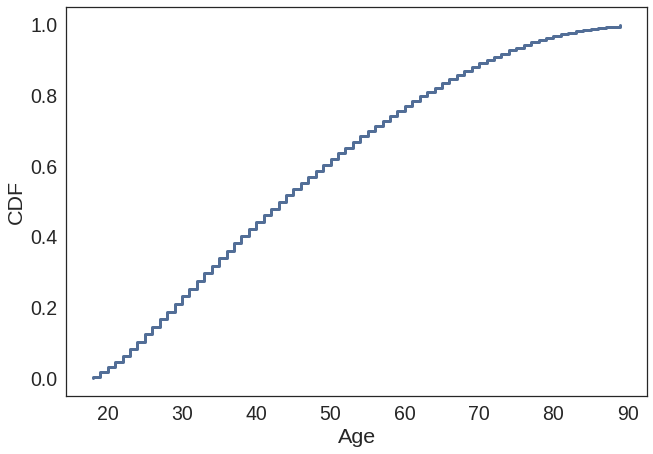

In [11]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [12]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

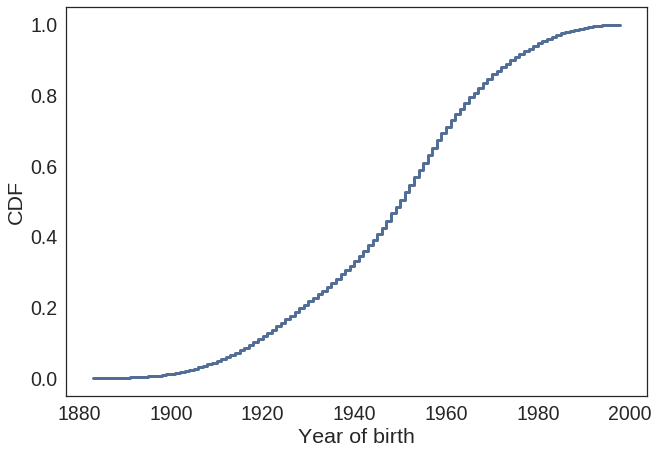

In [13]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [14]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [15]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      13
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [16]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [17]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     226
Name: gunlaw, dtype: int64

In [18]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [19]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     392
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [20]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
Name: year, dtype: int64

In [21]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [22]:
center_factors(gss)

Create the dependent variables

In [23]:
gss['favor'] = (gss.gunlaw == 1.0).astype(int)
gss.loc[gss.gunlaw.isnull(), 'favor'] = np.nan

gss['gunhome'] = (gss.owngun == 1.0).astype(int)
gss.loc[gss.owngun.isnull(), 'gunhome'] = np.nan


## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [24]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,ballot,cohort,rowngun,owngun,gunlaw,polviews,age,id_,wtssall,...,cohort5,cohort10,ones,c,a,c2,a2,ac,favor,gunhome
0,1972,0,1939.0,0,NaN,2.0,0,33.0,1007,0.8893,...,1939.5,1930.0,1.0,-27.0,-14.0,729.0,196.0,378.0,0.0,NaN
1,1972,0,1908.0,0,NaN,2.0,0,64.0,958,0.8893,...,1909.5,1900.0,1.0,-58.0,17.0,3364.0,289.0,-986.0,0.0,NaN
2,1972,0,1894.0,0,NaN,1.0,0,78.0,529,1.3339,...,1894.5,1890.0,1.0,-72.0,31.0,5184.0,961.0,-2232.0,1.0,NaN
3,1972,0,1900.0,0,NaN,1.0,0,72.0,213,0.8893,...,1899.5,1900.0,1.0,-66.0,25.0,4356.0,625.0,-1650.0,1.0,NaN
4,1972,0,1927.0,0,NaN,2.0,0,45.0,1148,1.7786,...,1929.5,1920.0,1.0,-39.0,-2.0,1521.0,4.0,78.0,0.0,NaN


### Run logistic models



In [25]:
formula = 'favor ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.543336
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40440
Model:                          Logit   Df Residuals:                    40437
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:               0.0004783
Time:                        13:45:09   Log-Likelihood:                -21973.
converged:                       True   LL-Null:                       -21983.
                                        LLR p-value:                 2.716e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2720      0.022     57.777      0.000       1.229       1.315
c              0.0040      0.001      4.578      0.000       0.002       0.006
a              0.0037      0.001      3.438      0.001       0.002       0.006
==============================================================================
"""

In [26]:
def model_predict(model, new):
    res = new.copy()
    res['pred'] = model.predict(new) * 100
    res['diff'] = res.pred - res.pred[0]
    return res[['cohort', 'age',  'pred', 'diff']]

In [27]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [28]:
model_predict(model, new)

,cohort,age,pred,diff
0,1971,46,78.387566,0.000000
1,2000,18,78.616114,0.228548
2,2000,46,80.296350,1.908784


In [29]:
formula = 'favor ~ c + a + c2 + a2 + ac'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.540670
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40440
Model:                          Logit   Df Residuals:                    40434
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                0.005383
Time:                        13:45:10   Log-Likelihood:                -21865.
converged:                       True   LL-Null:                       -21983.
                                        LLR p-value:                 3.964e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0200      0.028     36.849      0.000       0.966       1.074
c             -0.0339      0.003    -11.692      0.000      -0.040      -0.028
a             -0.0330      0.003    -10.735      0.000      -0.039      -0.027
c2            -0.0010   7.05e-05    -13.675      0.000      -0.001      -0.001
a2            -0.0007   8.98e-05     -7.790      0.000      -0.001      -0.001
ac            -0.0019      0.000    -12.820      0.000      -0.002      -0.002
==============================================================================
"""

In [30]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [31]:
model_predict(model, new)

,cohort,age,pred,diff
0,1971,46,70.433284,0.000000
1,2000,18,72.426804,1.993520
2,2000,46,24.017373,-46.415911


In [32]:
formula = 'gunhome ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.671896
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                gunhome   No. Observations:                37546
Model:                          Logit   Df Residuals:                    37543
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                 0.01455
Time:                        13:45:10   Log-Likelihood:                -25227.
converged:                       True   LL-Null:                       -25599.
                                        LLR p-value:                1.875e-162
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6997      0.020    -35.577      0.000      -0.738      -0.661
c             -0.0209      0.001    -25.099      0.000      -0.023      -0.019
a             -0.0135      0.001    -13.640      0.000      -0.015      -0.012
==============================================================================
"""

In [33]:
formula = 'gunhome ~ c + a + a2 + c2'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.666562
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                gunhome   No. Observations:                37546
Model:                          Logit   Df Residuals:                    37541
Method:                           MLE   Df Model:                            4
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                 0.02237
Time:                        13:45:10   Log-Likelihood:                -25027.
converged:                       True   LL-Null:                       -25599.
                                        LLR p-value:                1.133e-246
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5933      0.022    -26.380      0.000      -0.637      -0.549
c             -0.0326      0.001    -26.226      0.000      -0.035      -0.030
a             -0.0108      0.001    -10.786      0.000      -0.013      -0.009
a2            -0.0003   3.93e-05     -7.212      0.000      -0.000      -0.000
c2            -0.0003   2.45e-05    -12.609      0.000      -0.000      -0.000
==============================================================================
"""

## Favor gunlaw

In [34]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

In [35]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        series.replace([0.0], np.nan, inplace=True)
        thinkplot.plot(series.dropna(), color=color, label=label)

In [36]:
def plot_gunlaw(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [37]:
grouped_year = sample.groupby(['year'])
make_series_seq(grouped_year, ['favor'])

[year
 1972    72.762148
 1973    74.473863
 1974    77.182131
 1975    72.866065
 1976    71.932203
 1977    74.866310
 1978          NaN
 1980    70.391061
 1982    74.833703
 1983          NaN
 1984    71.796657
 1985    74.567244
 1986          NaN
 1987    73.544375
 1988    74.377593
 1989    79.684418
 1990    81.757508
 1991    82.466871
 1993    83.742911
 1994    80.324544
 1996    82.811698
 1998    82.446517
 2000    82.608696
 2002    82.333697
 2004    78.801843
 2006    79.969955
 2008    79.455253
 2010    74.344262
 2012    72.427035
 2014    73.913043
 2016    69.909139
 Name: favor, dtype: float64]

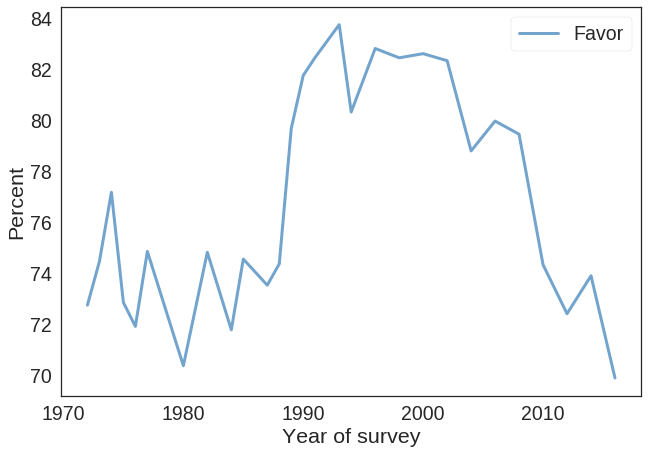

In [38]:
plot_gunlaw(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [39]:
grouped_age = sample.groupby(['age_group'])

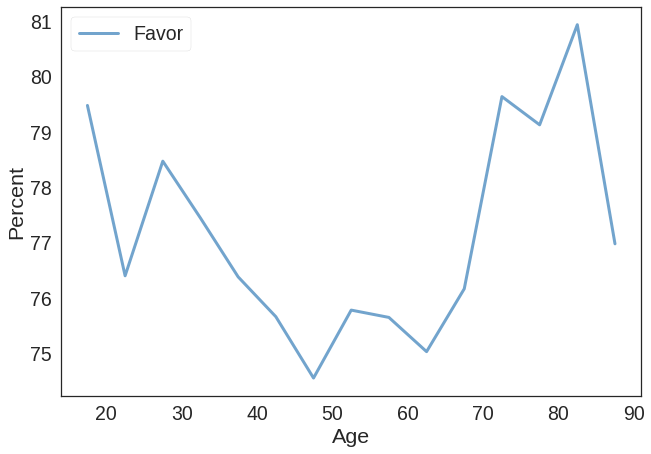

In [40]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [41]:
grouped_cohort = sample.groupby(['cohort5'])

In [42]:
heri = pd.read_csv('heri_gun_control.csv')

In [43]:
heri.year

0     1989
1     1990
2     1991
3     1992
4     1993
5     1994
6     1995
7     1996
8     1997
9     1998
10    1999
11    2000
12    2001
13    2002
14    2003
15    2004
16    2005
17    2006
18    2007
19    2008
20    2010
21    2013
Name: year, dtype: int64

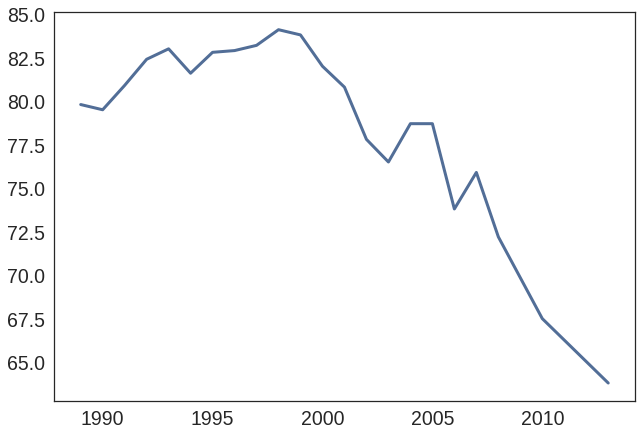

In [44]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree)

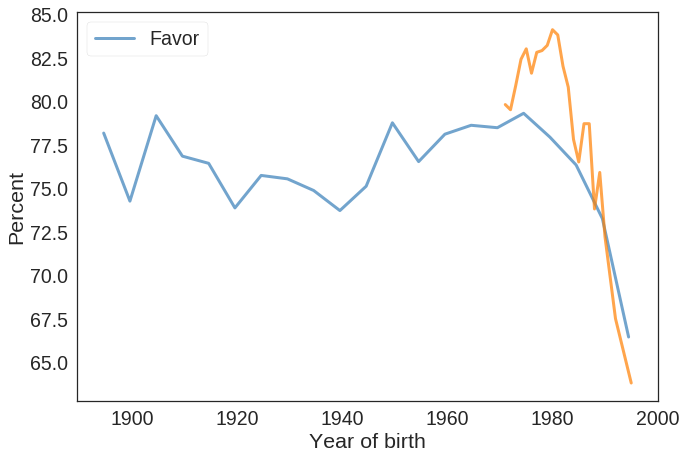

In [45]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [46]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [47]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
model = make_logit_model(sample, 'favor', factors)

In [48]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [49]:
age = sample.loc[sample.year==2016, 'age']

In [50]:
predict_logit_model(age, model, 1976, factors)

74.55372768638432

In [51]:
predict_logit_model(age, model, 2016, factors)

72.593629681484074

In [52]:
predict_logit_model(age, model, 2026, factors)

62.163108155407777

In [53]:
predict_logit_model(age, model, 2036, factors)

44.137206860343014

In [54]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [55]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

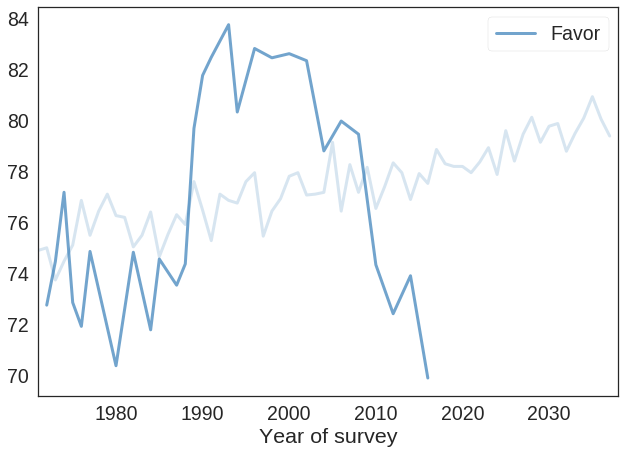

In [56]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

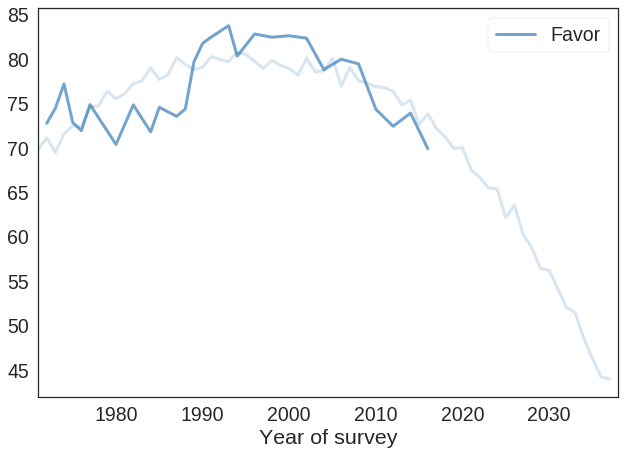

In [57]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [58]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [59]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [60]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [61]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [62]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Gun permits

In [63]:
iters = 101

In [64]:
groupvar = 'year'
varnames = ['favor']

In [65]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

Writing permit_year.png


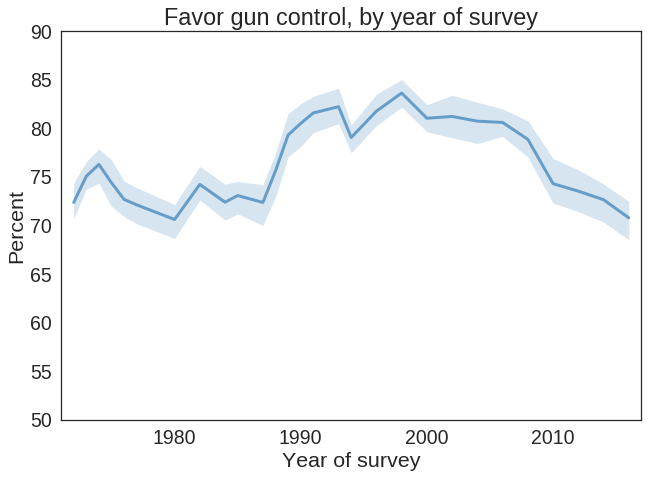

In [66]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

thinkplot.SaveFormat('permit_year', 'png')

In [67]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

Writing permit_cohort.png


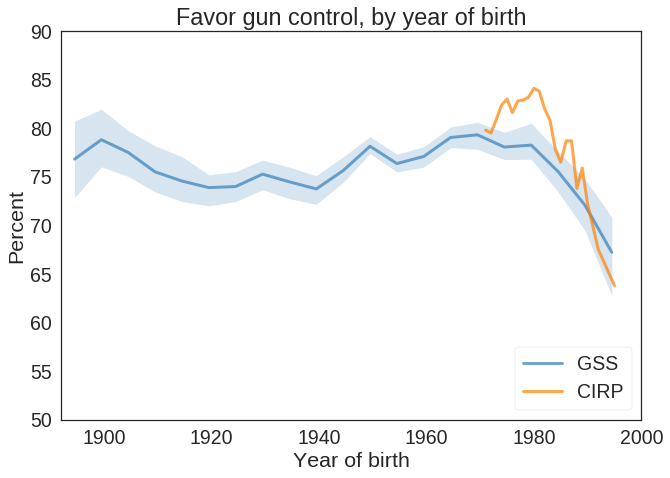

In [68]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('permit_cohort', 'png')

In [69]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

Writing permit_pred.png


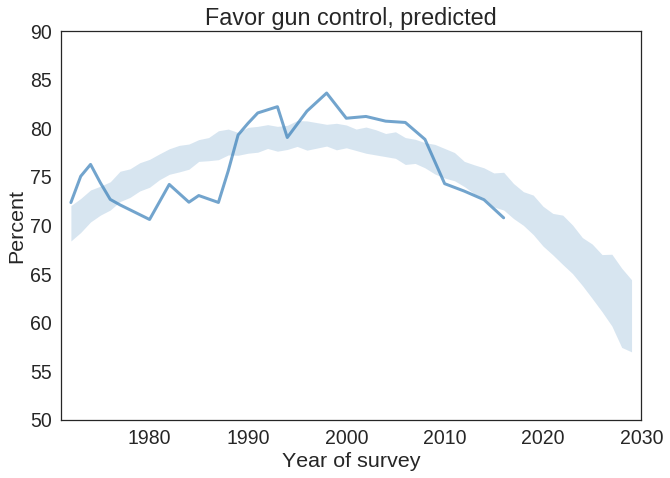

In [70]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', 'png')

Breakdown by political view

In [71]:
gss.polviews.value_counts()

4    20435
5     8398
6     7844
0     6755
3     6742
2     6218
8     2227
7     1723
1     1554
9      348
Name: polviews, dtype: int64

In [72]:
liberal = gss[gss.polviews.isin([1,2,3])]
liberal.shape

(14514, 21)

In [73]:
conservative = gss[gss.polviews.isin([5,6,7])]
conservative.shape

(17965, 21)

In [74]:
moderate = gss[gss.polviews == 4]
moderate.shape

(20435, 21)

In [75]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

Writing permit_cohort_polview.png


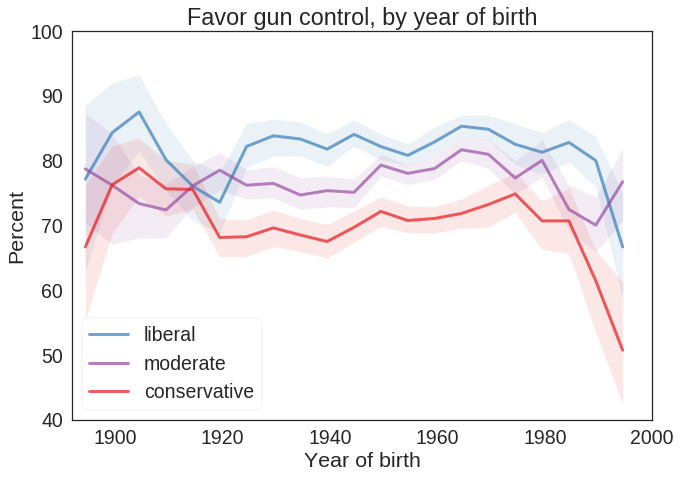

In [76]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_polview', 'png')

## Gun in home

In [77]:
groupvar = 'year'
varnames = ['gunhome']

In [78]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

Writing gunhome_year.png


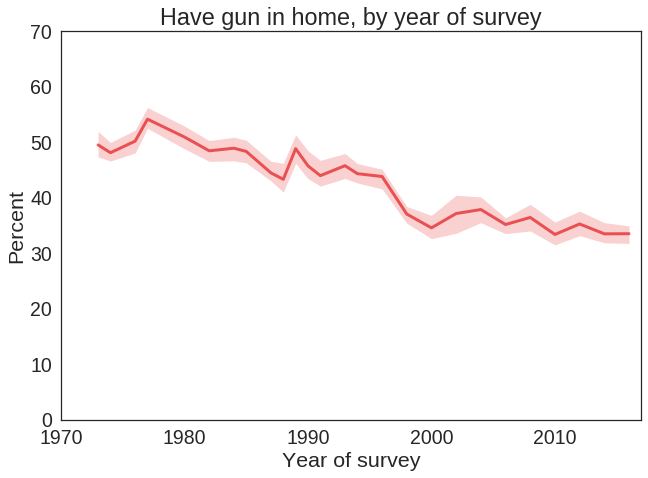

In [79]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', 'png')

In [80]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

Writing gunhome_cohort.png


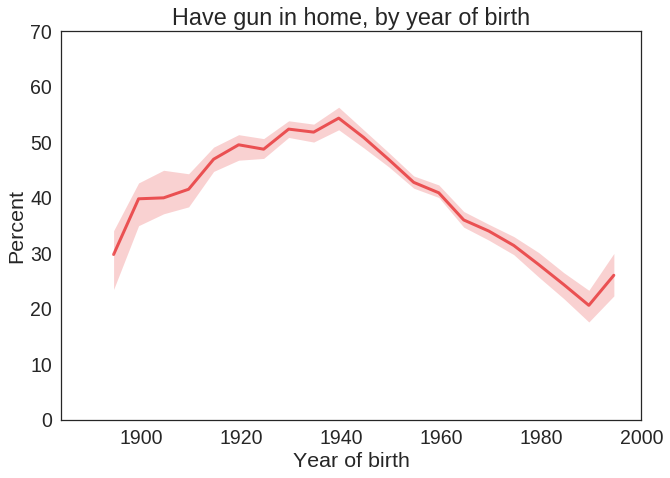

In [81]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', 'png')

In [82]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

Writing gunhome_pred.png


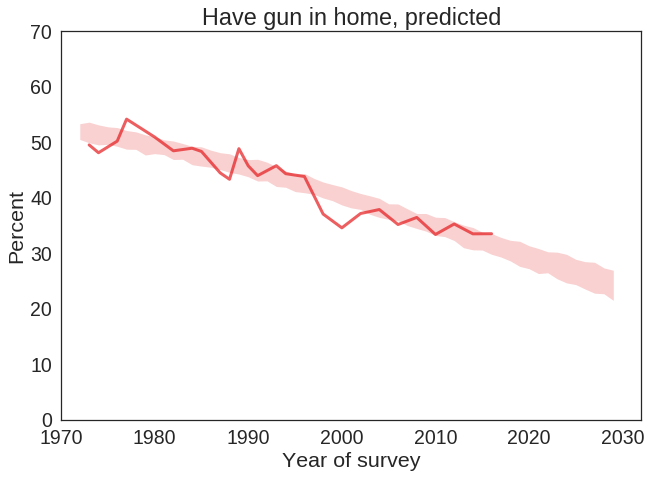

In [83]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', 'png')